In [5]:
import pandas as pd
# Define a function to load data dynamically
def load_data(file_path):
    # Load data from each sheet into separate dataframes
    locations_df = pd.read_excel(file_path, sheet_name='locations', usecols="A").dropna()
    nurses_df = pd.read_excel(file_path, sheet_name='nurses', usecols="A:B").dropna()
    patients_df = pd.read_excel(file_path, sheet_name='patients', usecols="A:C").dropna()
    task_execution_time_df = pd.read_excel(file_path, sheet_name='task_execution_time', usecols="A:B").dropna()
    medication_adherence_df = pd.read_excel(file_path, sheet_name='medication_adherence', usecols="A:H").replace('Not Applicable', pd.NA).dropna(how='all', subset=['M', 'T', 'W', 'Th', 'F', 'S', 'Su'])
    physical_therapy_adherence_df = pd.read_excel(file_path, sheet_name='physical_therapy_adherence', usecols="A:H").replace('Not Applicable', pd.NA).dropna(how='all', subset=['M', 'T', 'W', 'Th', 'F', 'S', 'Su'])
    distance_matrix_df = pd.read_excel(file_path, sheet_name='distance_matrix', header=None).dropna(how='all')

    # Process data
    task_execution_time_df['Time'] = task_execution_time_df['Time'].str.extract('(\d+)').astype(int)
    nurses_df['skillset'] = nurses_df['skillset'].str.split(', ')
    patients_df['needs'] = patients_df['needs'].str.split(', ')

    for col in ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']:
        medication_adherence_df[col] = pd.to_numeric(medication_adherence_df[col] * 100, errors='coerce')
        physical_therapy_adherence_df[col] = pd.to_numeric(physical_therapy_adherence_df[col] * 100, errors='coerce')

    for col in ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']:
        medication_adherence_df[col] = (medication_adherence_df[col]).astype('Int64', errors='ignore')
        physical_therapy_adherence_df[col] = (physical_therapy_adherence_df[col]).astype('Int64', errors='ignore')
    
    
    return {
        "locations": locations_df,
        "nurses": nurses_df,
        "patients": patients_df,
        "task_execution_time": task_execution_time_df,
        "medication_adherence": medication_adherence_df,
        "physical_therapy_adherence": physical_therapy_adherence_df,
        "distance_matrix": distance_matrix_df
    }


# Load data dynamically
file_path = './nurse_schedule_data_large_VA.xlsx'
data = load_data(file_path)

# Extract individual dataframes from the data dictionary
locations_df = data["locations"]
nurses_df = data["nurses"]
patients_df = data["patients"]
task_execution_time_df = data["task_execution_time"]
medication_adherence_df = data["medication_adherence"]
physical_therapy_adherence_df = data["physical_therapy_adherence"]
distance_matrix_df = data["distance_matrix"]

# Display the first few rows of each dataframe to verify the dynamic data loading
for name, df in data.items():
    print(f"{name}:\n{df.head()}\n")

days = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']


locations:
       Unnamed: 0
0      Alexandria
1         Roanoke
2         Norfolk
3  Virginia Beach
4      Chesapeake

nurses:
        id                                           skillset
0  Nurse_1                                       [wound care]
1  Nurse_2  [drawing blood, physical therapy, personal hyg...
2  Nurse_3                                 [physical therapy]
3  Nurse_4  [physical therapy, medication, drawing blood, ...
4  Nurse_5  [personal hygiene assistance, medication, phys...

patients:
          id                        needs        location
0  Patient_1   [administering injections]  Fredericksburg
1  Patient_2           [physical therapy]       Lynchburg
2  Patient_3  [drawing blood, medication]       Lynchburg
3  Patient_4           [physical therapy]         Roanoke
4  Patient_5              [drawing blood]      Chesapeake

task_execution_time:
                       Task  Time
0                medication    20
1             drawing blood    89
2          physic

In [6]:
from gurobipy import Model, GRB, quicksum
import numpy as np

model = Model("nurse_scheduling")

# Get the number of nurses, patients, tasks, and days
day_dict = {'M': 0, 'T': 1, 'W': 2, 'Th': 3, 'F': 4, 'S': 5, 'Su': 6}
num_nurses = len(nurses_df)
num_patients = len(patients_df)
num_tasks = len(task_execution_time_df)
num_days = 7  # Days in a week
task_list = task_execution_time_df['Task'].tolist()
#nurse_skills = nurses_df.iloc[i]['skillset']
# Convert adherence dataframes to dictionaries for easier access
medication_adherence_dict = medication_adherence_df.set_index('id').T.to_dict('dict')
physical_therapy_adherence_dict = physical_therapy_adherence_df.set_index('id').T.to_dict('dict')


# Define Decision Variables
#x[i, j, k]: A binary variable that determines whether nurse i is assigned to patient j on day k.
x = model.addVars(num_nurses, num_patients, num_days, vtype=GRB.BINARY, name="x")
#w[i, k]: A binary variable that indicates whether nurse i is working on day k.
w = model.addVars(num_nurses, num_days, vtype=GRB.BINARY, name="w")
# p[i, m, k]: A binary variable that indicates whether nurse i is at location m on day k.
p = model.addVars(num_nurses, len(locations_df), num_days, vtype=GRB.BINARY, name="p")
#t[i, j, n, k]: A binary variable that indicates whether nurse i is performing task n for patient j on day k.
t = model.addVars(num_nurses, num_patients, num_tasks, num_days, vtype=GRB.BINARY, name="t")
#D[i, m, k]: A binary variable that indicates whether nurse i is at location m on day k.
D = model.addVars(num_nurses, len(locations_df), num_days-1, vtype=GRB.BINARY, name="D")


def get_adherence(patient_id, task, day):
    if task == 'medication':
        return medication_adherence_dict[patient_id][day] if patient_id in medication_adherence_dict and day in medication_adherence_dict[patient_id] else 0
    elif task == 'physical therapy':
        return physical_therapy_adherence_dict[patient_id][day] if patient_id in physical_therapy_adherence_dict and day in physical_therapy_adherence_dict[patient_id] else 0
    else:
        return 0


model.setObjective(
    quicksum(
        # If a nurse is assigned (t[i, j, task_list.index(task), d] is 1), use 100; otherwise, use get_adherence value
        100 * t[i, j, task_list.index(task), d] + get_adherence(j, task, list(day_dict.keys())[d])
        for i in range(num_nurses)
        for j in range(num_patients)
        for task in ['medication', 'physical therapy']
        for d in range(num_days)
    ),
    GRB.MAXIMIZE,
)



# Convert task execution time dataframe to dictionary for easier access
task_time_dict = task_execution_time_df.set_index('Task').to_dict()['Time']

# Adding the constraint that each nurse can work up to 10 hours in a day
for i in range(num_nurses):
    for d in range(num_days):
        model.addConstr(
            quicksum(
                t[i, j, k, d] * task_time_dict[task_list[k]]
                for j in range(num_patients)
                for k in range(num_tasks)
            ) <= 10 * 60,  # 10 hours converted to minutes
            name=f"daily_work_hours_nurse_{i}_day_{d}"
        )




#the sum of nurses day's working is <= 4
for i in range(num_nurses):
    model.addConstr(quicksum(w[i, k] for k in range(num_days)) <= 4, name=f"max_working_days_nurse_{i}")


# Add constraints to only assign necessary tasks to patients and ensure the task is in nurse's skillset
for i in range(num_nurses):
    nurse_skills = nurses_df.iloc[i]['skillset']
    for j in range(num_patients):
        for l in range(num_tasks):
            if task_list[l] not in patients_df.at[j, 'needs'] or task_list[l] not in nurse_skills:
                model.addConstr(quicksum(t[i, j, l, k] for k in range(num_days)) == 0)

                
# Get a dictionary with patient IDs as keys and lists of required tasks as values
patient_tasks_dict = patients_df.set_index('id')['needs'].to_dict()


# Constraint ensuring each nurse works in only one location in a given day
for i in range(num_nurses):
    for d in range(num_days):
        model.addConstr(
            quicksum(p[i, m, d] for m in range(len(locations_df))) <= 1,
            name=f"Nurse_{i}_Day_{d}_One_Location"
        )

# Adding constraints to link w and x variables
for i in range(num_nurses):
    for d in range(num_days):
        # Constraint 1: If a nurse is assigned to any task on a given day, set w[i, d] to 1
        model.addConstr(
            quicksum(t[i, j, k, d] for j in range(num_patients) for k in range(num_tasks)) <= w[i, d] * num_tasks * num_patients,
            name=f"working_day_assignment_link_1_nurse_{i}_day_{d}"
        )

        # Constraint 2: If w[i, d] is 0, the nurse cannot be assigned any task on that day
        model.addConstr(
            w[i, d] <= quicksum(t[i, j, k, d] for j in range(num_patients) for k in range(num_tasks)),
            name=f"working_day_assignment_link_2_nurse_{i}_day_{d}"
        )

# Constraints to link the p variable with the t variable
for i in range(num_nurses):
    for j in range(num_patients):
        m = locations_df.index[locations_df['Unnamed: 0'] == patients_df.iloc[j]['location']].tolist()[0]  # Getting the index of patient's location
        for n in range(num_tasks):
            for d in range(num_days):
                model.addConstr(
                    p[i, m, d] >= t[i, j, n, d],
                    name=f"Link_Location_Task_Nurse_{i}_Patient_{j}_Task_{n}_Day_{d}"
                )



# This constraint ensures that each necessary task for each patient is completed each day.
# It sums over the t variable for each task and requires that the sum be equal to the 
# number of patients that need that task performed on each day of the week.
for j, patient_id in enumerate(patients_df['id']):
    for l, task in enumerate(task_execution_time_df['Task']):
        if task not in ['medication', 'physical_therapy']:
            model.addConstr(
                quicksum(t[i, j, l, k] for i in range(num_nurses) for k in range(num_days)) == 
                (task in patient_tasks_dict[patient_id]) * num_days, 
                name=f"task_completion_{patient_id}_{task}"
            )


#only 1 nurse is doing a certain task for a certain patient on a certain day
for j in range(num_patients):
    for k in range(num_tasks):
        for d in range(num_days):
            model.addConstr(quicksum(t[i, j, k, d] for i in range(num_nurses)) <= 1, 
                            name=f"single_nurse_per_task_per_day_patient_{j}_task_{k}_day_{d}")


# restricts nurses to only work in same location for consecutive days
for i in range(num_nurses):
    for m in range(len(locations_df)):
        for k in range(num_days - 1):  # Exclude the last day
            model.addConstr(
                D[i, m, k] >= p[i, m, k] - p[i, m, k+1],
                name=f"Location_Change_Detection_1_Nurse_{i}_Location_{m}_Day_{k}"
            )
            model.addConstr(
                D[i, m, k] >= p[i, m, k+1] - p[i, m, k],
                name=f"Location_Change_Detection_2_Nurse_{i}_Location_{m}_Day_{k}"
            )

max_location_changes = 2  # Set desired limit
for i in range(num_nurses):
    model.addConstr(
        quicksum(D[i, m, k] for m in range(len(locations_df)) for k in range(num_days-1)) <= max_location_changes,
        name=f"Max_Location_Changes_Nurse_{i}"
    )



            
model.optimize()


if model.status == GRB.OPTIMAL:
    print('Objective Value: ', model.objVal)
    for i in range(num_nurses):
        # Get the skills of the nurse
        nurse_skills = nurses_df.iloc[i]['skillset']
        
        # Calculate total hours worked in the week for the nurse
        total_minutes_worked = sum(
            t[i, j, k, d].x * task_time_dict[task_list[k]]
            for j in range(num_patients)
            for k in range(num_tasks)
            for d in range(num_days)
        )
        total_hours_worked = total_minutes_worked / 60  # Convert minutes to hours

        print(f'Nurse_{i+1} \n Skills: {nurse_skills} \n Total Hours Worked: {total_hours_worked:.2f}\n')
        for k in range(num_days):
            working = False
            tasks_for_the_day = []
            daily_minutes_worked = 0  # Initialize daily_minutes_worked variable
            for j in range(num_patients):
                for l in range(num_tasks):
                    if t[i, j, l, k].x > 0.5:  # If the task is assigned
                        location = patients_df.iloc[j]['location']
                        task_name = task_list[l]
                        tasks_for_the_day.append((j, task_name, location))
                        daily_minutes_worked += task_time_dict[task_name]  # Add time for the task to daily total
                        working = True
            daily_hours_worked = daily_minutes_worked / 60  # Convert daily_minutes_worked to hours
            if working:
                print(f'  Day {list(day_dict.keys())[k]}: Working (Total Hours Worked: {daily_hours_worked:.2f})')
                for task in tasks_for_the_day:
                    print(f'    - Helping Patient_{task[0]+1} with {task[1]} in {task[2]}')
                print('\n')
            else:
                print(f'  Day {list(day_dict.keys())[k]}: Off\n')
else:
    print('No optimal solution found. Status code:', model.status)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 246832 rows, 251850 columns and 1632974 nonzeros
Model fingerprint: 0xe1a23b9f
Variable types: 0 continuous, 251850 integer (251850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 200350 rows and 207417 columns
Presolve time: 0.90s
Presolved: 46482 rows, 44433 columns, 278502 nonzeros
Variable types: 0 continuous, 44433 integer (44426 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 4.830000e+04, 9885 iterations, 0.23 seconds (0.40 work units)

    Nodes    |    Curre

In [ ]:
# 2. Task Completion Check
for j in range(num_patients):
    patient_tasks = patients_df.iloc[j]['needs']
    for task in patient_tasks:
        task_index = task_list.index(task)
        assigned_times = sum(t[i, j, task_index, d].x for i in range(num_nurses) for d in range(num_days))
        assert assigned_times == num_days, f"Patient {j}'s task {task} not completed daily."


AssertionError: Patient 0's task medication not completed daily.

In [ ]:
# 3. Single Location Check
for i in range(num_nurses):
    for d in range(num_days):
        locations_worked = sum(p[i, m, d].x for m in range(len(locations_df)))
        assert locations_worked <= 1, f"Nurse {i} works in more than one location on day {d}."


In [ ]:
# 4. Skill Matching Check
for i in range(num_nurses):
    nurse_skills = nurses_df.iloc[i]['skillset']
    for j in range(num_patients):
        for k in range(num_tasks):
            if t[i, j, k, d].x > 0.5 and task_list[k] not in nurse_skills:
                raise AssertionError(f"Nurse {i} assigned task {task_list[k]} which is not in their skillset.")


In [ ]:
# 5. Nurse's Work Days Check
for i in range(num_nurses):
    days_worked = sum(w[i, d].x for d in range(num_days))
    assert days_worked <= 4, f"Nurse {i} works more than 4 days in a week."


In [ ]:
# 6. Only One Nurse Per Task Per Day Check
for j in range(num_patients):
    for k in range(num_tasks):
        for d in range(num_days):
            nurses_assigned = sum(t[i, j, k, d].x for i in range(num_nurses))
            assert nurses_assigned <= 1, f"More than one nurse assigned to Patient {j} for Task {k} on Day {d}."


In [11]:
import pandas as pd

# Step 1: Parse Text File
with open('./LargeData.txt', 'r') as file:
    lines = file.readlines()

excel_writer = pd.ExcelWriter('./nurse_schedules_large.xlsx', engine='xlsxwriter')

current_nurse = None
schedule_data = []
for line in lines:
    line = line.strip()
    if line.startswith("Nurse_"):
        # Write previous nurse's schedule to Excel, if exists
        if schedule_data:
            schedule_df = pd.DataFrame(schedule_data, columns=['Day', 'Patient', 'Task', 'Location'])
            schedule_df.to_excel(excel_writer, sheet_name=current_nurse, index=False)
            schedule_data = []  # reset schedule data for next nurse
        current_nurse = line  # set current nurse
    elif line.startswith("Day") and "Working" in line:
        current_day = line.split(":")[0].strip()
    elif line.startswith("- Helping"):
        task_info = line.split(" ")
        patient = task_info[2]
        task = task_info[4]
        location = task_info[-1]
        schedule_data.append([current_day, patient, task, location])

# Write the last nurse's schedule to Excel
if schedule_data:
    schedule_df = pd.DataFrame(schedule_data, columns=['Day', 'Patient', 'Task', 'Location'])
    schedule_df.to_excel(excel_writer, sheet_name=current_nurse, index=False)

# Save the Excel file
excel_writer.save()

/var/folders/t_/v0rbfst90tz2msnttg7gck640000gn/T/ipykernel_60975/314090525.py:35: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()


In [12]:
def extract_work_hours(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []  # Initialize the 2D list to store work hours
    current_hours = [0, 0, 0, 0, 0, 0, 0]  # Initialize work hours for the current nurse
    day_mapping = {'M': 0, 'T': 1, 'W': 2, 'Th': 3, 'F': 4, 'S': 5, 'Su': 6}  # Map days to indices

    for line in lines:
        line = line.strip()
        if line.startswith("Nurse_"):
            # If we encounter a new nurse, append the hours of the previous nurse to data
            if current_hours != [0, 0, 0, 0, 0, 0, 0]:
                data.append(current_hours)
                current_hours = [0, 0, 0, 0, 0, 0, 0]  # Reset work hours for the new nurse
        elif line.startswith("Day") and "Working" in line:
            # Extract the day and total hours worked
            parts = line.split(" ")
            day = parts[1][:-1]  # Remove the colon at the end of the day
            hours = float(parts[-1][1:-1])  # Remove the parentheses around the hours
            current_hours[day_mapping[day]] = hours  # Add the hours to the corresponding day

    # Add the hours of the last nurse to data
    if current_hours != [0, 0, 0, 0, 0, 0, 0]:
        data.append(current_hours)

    return data


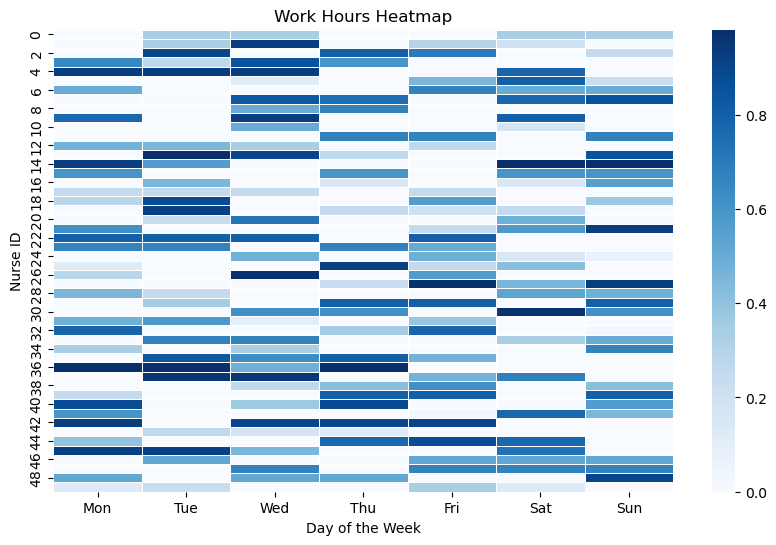

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume data is a 2D list where data[i][j] is the hours worked by nurse i on day j
# You need to extract this information from your schedule first

# Use the function to extract work hours from the text file
data = extract_work_hours('./LargeData.txt')
# Convert data to a Pandas DataFrame
df = pd.DataFrame(data, columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=False, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Work Hours Heatmap')
plt.xlabel('Day of the Week')
plt.ylabel('Nurse ID')
plt.show()

In [24]:
from collections import defaultdict

def extract_location_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize dictionary to store nurse count per location per day
    location_data = {day: defaultdict(int) for day in ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']}
    
    current_day = None

    for line in lines:
        line = line.strip()
        if line.startswith("Day"):
            # Extract the day
            current_day = line.split(" ")[1][:-1]  # Get the day identifier
        elif line.startswith("- Helping"):
            # Extract location and increment the count
            current_location = line.split(" ")[-1]
            location_data[current_day][current_location] += 1  # Increment nurse count

    return location_data

# Use the function to extract location data from the text file
location_data = extract_location_data("./LargeData.txt")


In [26]:
import plotly.express as px


# Step 2: Get Location Coordinates
locations = {
    'Alexandria': (38.8048, -77.0469),
    'Roanoke': (37.2707, -79.9414),
    'Norfolk': (36.8508, -76.2859),
    'Beach': (36.8529, -75.9780),
    'Chesapeake': (36.7682, -76.2875),
    'Richmond': (37.5407, -77.4360),
    'Williamsburg': (37.2707, -76.7075),
    'Lynchburg': (37.4138, -79.1422),
    'Fredericksburg': (38.3032, -77.4605),
    'Arlington': (38.8816, -77.0910)
}

# Step 3: Create Bubble Map for Each Day
for day, data in location_data.items():
    # Convert data to a format suitable for Plotly
    plot_data = []
    for location, count in data.items():
        lat, lon = locations[location]
        plot_data.append((location, lat, lon, count))

    df = pd.DataFrame(plot_data, columns=['Location', 'Latitude', 'Longitude', 'Nurse Count'])

    # Create the bubble map
    fig = px.scatter_mapbox(df,
                            lat='Latitude',
                            lon='Longitude',
                            text='Location',
                            size='Nurse Count',
                            title=f'Nurse Distribution on {day}',
                            mapbox_style="open-street-map",  # or "carto-positron", or you can use mapbox with a token
                            zoom=5,  # Adjust zoom level as needed
                            center={"lat": 37.5109, "lon": -78.6664})  # Center on Virginia

    fig.show()
